# Spark Query Plan and Lazy Evaluations

### Lazy Transformations¶
- One of the main features of Spark is that transformations are lazily evaulated
- This means that only when the results are needed (.show, .collect, count etc) only then are the transformations applied
- In this way Spark can create an execution plan (a DAG) which is optimized (apply the later transformations on the smaller data sets)

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Lazy Evaluation").getOrCreate()
print("Spark Session Initialised")

Spark Session Initialised


In [2]:
from pyspark.sql.functions import col

In [3]:
df = spark.read.format('csv').option("header", True).option("inferSchema", True).load('Pomofocus 2024 - pomofocus_cleaned.csv')
df.printSchema()

root
 |-- Index: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- task: string (nullable = true)
 |-- minutes: integer (nullable = true)
 |-- startTime: timestamp (nullable = true)
 |-- endTime: timestamp (nullable = true)
 |-- Task Group: string (nullable = true)
 |-- Streak: string (nullable = true)



In [11]:
df.show(5)

+-----+----------+--------+-------+-------------------+-------------------+--------------------+------+
|Index|      date|    task|minutes|          startTime|            endTime|          Task Group|Streak|
+-----+----------+--------+-------+-------------------+-------------------+--------------------+------+
|    0|2024-01-02|  German|      7|2025-01-03 10:33:00|2025-01-03 10:40:00|     Learning German|  NULL|
|    1|2024-01-02|  German|     17|2025-01-03 11:35:00|2025-01-03 11:52:00|     Learning German|  NULL|
|    2|2024-01-02|Big Data|     27|2025-01-03 11:57:00|2025-01-03 12:24:00|Masters Course Cu...|  NULL|
|    4|2024-01-03|Big Data|     54|2025-01-03 11:41:00|2025-01-03 12:55:00|Masters Course Cu...|  NULL|
|    5|2024-01-04|  German|     27|2025-01-03 10:48:00|2025-01-03 11:15:00|     Learning German|  NULL|
+-----+----------+--------+-------+-------------------+-------------------+--------------------+------+
only showing top 5 rows



- Always remember to start reading from bottom up
- The most important plan is "Physical Plan" because that is the plan that actaully gets executed on the cluster
  
## Some Common Keywords in Spark Query Plans
- **Project** - Selecting columns, pushing projections
- **Filter** - filter rows based on conditions
- **FileScan** - Reading files
- **Join**
- **Aggregate** - Grouping and summarising data
- **Sort/Order By**
- **Union** - Combine rows from multiple dataframes
- **Window** - window functions

#### Important Attribute Keywords
- **Batched** - is batch processing enabled
- **PushedFilters** - Filter has been pushed closer to data source
- **BroadcastHashJoin** - broadcast join, smaller dataset sent to all nodes
- **Exchange** - Represents a shuffle operations

### How and Why Spark Creates an Execution Plan?
- The Why is clear - it is to optimise, lets cover the How
- Spark typically first checks for any filters and checks if they can be combined. Check example below
- Spark typically priotizes the operations as follows
- 1. Filter Operations
  2. Projection (Columns Pruning) - selecting only those columns that are needed
  3. After filtering and narrowing down the column Spark focuses on Aggregation and Joins

1. Parsed Logical Plan - Spark just converts your code into tree operations. Based on the raw code
2. Analysed Logical Plan - Here the plan undergoes checks like - does the column or table referenced exist, are all operations valid
3. Optimised Logical Plan - Here is where the optimisation happens - combining filters, selecting columns, applying joins etc
4. Physical Plan - This is the final executable plan, it shows how - how to join tables, how to group data, same stage operations
ctions) 

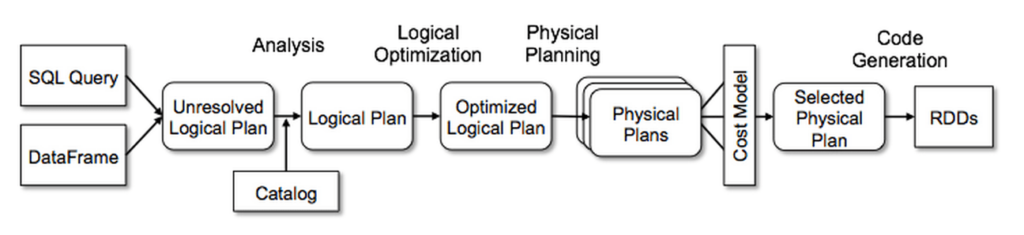

## Narrow Transformations
These transformations do not involve a shuffle, examples include
- filter,
- add (adding new column)
- alter (altering existing column)
- select

In [17]:
df_narrow_transform = df.filter(col('Task Group')=='Learning German')\
                        .withColumn('hours', col('minutes')/60)\
                        .select('date','task','Task Group','minutes','hours')

df_narrow_transform.show(5)

+----------+------+---------------+-------+-------------------+
|      date|  task|     Task Group|minutes|              hours|
+----------+------+---------------+-------+-------------------+
|2024-01-02|German|Learning German|      7|0.11666666666666667|
|2024-01-02|German|Learning German|     17| 0.2833333333333333|
|2024-01-04|German|Learning German|     27|               0.45|
|2024-01-06|German|Learning German|     21|               0.35|
|2024-01-16|German|Learning German|     17| 0.2833333333333333|
+----------+------+---------------+-------+-------------------+
only showing top 5 rows



In [32]:
df_narrow_transform.explain(mode="formatted")

== Physical Plan ==
* Project (3)
+- * Filter (2)
   +- Scan csv  (1)


(1) Scan csv 
Output [4]: [date#198, task#199, minutes#200, Task Group#203]
Batched: false
Location: InMemoryFileIndex [file:/home/jovyan/Pomofocus 2024 - pomofocus_cleaned.csv]
PushedFilters: [IsNotNull(Task Group), EqualTo(Task Group,Learning German)]
ReadSchema: struct<date:date,task:string,minutes:int,Task Group:string>

(2) Filter [codegen id : 1]
Input [4]: [date#198, task#199, minutes#200, Task Group#203]
Condition : (isnotnull(Task Group#203) AND (Task Group#203 = Learning German))

(3) Project [codegen id : 1]
Output [5]: [date#198, task#199, Task Group#203, minutes#200, (cast(minutes#200 as double) / 60.0) AS hours#310]
Input [4]: [date#198, task#199, minutes#200, Task Group#203]




### Reading the Spark Query Plan for the above Narrow transform
1. The physical plan above starts with a FileScan
2. It only selects these columns - date, taks, minutes, Task Group
3. Spark automatically applies a filter **isnotnull(Task Group#203)** for optimisation and then comes the filter we applied **(Task Group#203 = Learning German)**
4. Then finally the hours custom calculated column is created **(cast(minutes#200 as double) / 60.0) AS hours#310**

-------
-------

## Wide Transformations

### 1. Repartition
Redistributing the data. There is a partitioning scheme involved (pattern of how data is partitioned)

In [19]:
df.rdd.getNumPartitions()

1

In [33]:
df.repartition(4).explain(mode="formatted")

== Physical Plan ==
AdaptiveSparkPlan (3)
+- Exchange (2)
   +- Scan csv  (1)


(1) Scan csv 
Output [8]: [Index#197, date#198, task#199, minutes#200, startTime#201, endTime#202, Task Group#203, Streak#204]
Batched: false
Location: InMemoryFileIndex [file:/home/jovyan/Pomofocus 2024 - pomofocus_cleaned.csv]
ReadSchema: struct<Index:int,date:date,task:string,minutes:int,startTime:timestamp,endTime:timestamp,Task Group:string,Streak:string>

(2) Exchange
Input [8]: [Index#197, date#198, task#199, minutes#200, startTime#201, endTime#202, Task Group#203, Streak#204]
Arguments: RoundRobinPartitioning(4), REPARTITION_BY_NUM, [plan_id=323]

(3) AdaptiveSparkPlan
Output [8]: [Index#197, date#198, task#199, minutes#200, startTime#201, endTime#202, Task Group#203, Streak#204]
Arguments: isFinalPlan=false




### 2. Coalesce
- Reducing the no. of partitions
- however shuffle is not always involved unless the no. of partitions is less than no. of executors.
- Say for instance your data is distributed in 3 nodes, with each nodes having 2 partitions (i.e total 6 partitions), if you use Coalesce to reduce partitions to 2 then some of the partitions from the 3rd executor will need to shift to the either two available.


In [27]:
df.rdd.getNumPartitions()

1

In [24]:
df.coalesce(2).explain(True)

== Parsed Logical Plan ==
Repartition 2, false
+- Relation [Index#197,date#198,task#199,minutes#200,startTime#201,endTime#202,Task Group#203,Streak#204] csv

== Analyzed Logical Plan ==
Index: int, date: date, task: string, minutes: int, startTime: timestamp, endTime: timestamp, Task Group: string, Streak: string
Repartition 2, false
+- Relation [Index#197,date#198,task#199,minutes#200,startTime#201,endTime#202,Task Group#203,Streak#204] csv

== Optimized Logical Plan ==
Repartition 2, false
+- Relation [Index#197,date#198,task#199,minutes#200,startTime#201,endTime#202,Task Group#203,Streak#204] csv

== Physical Plan ==
Coalesce 2
+- FileScan csv [Index#197,date#198,task#199,minutes#200,startTime#201,endTime#202,Task Group#203,Streak#204] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/jovyan/Pomofocus 2024 - pomofocus_cleaned.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Index:int,date:date,task:string,minutes:int,start

In [25]:
df.rdd.getNumPartitions()

1

### 3. Joins

- **Hashpartition**
- Type of partitioning scheme that applies a hash function on the specified columns and assigns a partition to the data based on the hash value. Records with same keys will go the same container. Say you partitioning by customer_id, then in this all the records with customer_id = 1 will go to partition #1.
- hash(key)%no. of partitions = partition#
 

In [4]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [6]:
df_2 = spark.read.format('csv').option('header',True).option('inferSchema',True).load("report (5).csv")
df_2.show(5)

+--------+-------+--------------------+-------+-------------------+-------------------+
|    date|project|                task|minutes|          startTime|            endTime|
+--------+-------+--------------------+-------+-------------------+-------------------+
|20241220|   NULL|        UI UX Unit 5|     27|2025-01-04 12:21:00|2025-01-04 12:48:00|
|20241220|   NULL|        UI UX Unit 6|     54|2025-01-04 12:59:00|2025-01-04 14:12:00|
|20241220|   NULL|        Learn German|      0|2025-01-04 14:42:00|2025-01-04 14:42:00|
|20241220|   NULL|        Learn German|     27|2025-01-04 18:18:00|2025-01-04 18:45:00|
|20241220|   NULL|Data Engineering ...|     27|2025-01-04 19:09:00|2025-01-04 19:36:00|
+--------+-------+--------------------+-------+-------------------+-------------------+
only showing top 5 rows



In [7]:
df_joined = (df_2.join(df, how='inner', on='task'))
df_joined.show(5)

+--------------------+--------+-------+-------+-------------------+-------------------+-----+----------+-------+-------------------+-------------------+--------------------+------+
|                task|    date|project|minutes|          startTime|            endTime|Index|      date|minutes|          startTime|            endTime|          Task Group|Streak|
+--------------------+--------+-------+-------+-------------------+-------------------+-----+----------+-------+-------------------+-------------------+--------------------+------+
|Apply to Working ...|20241220|   NULL|     27|2025-01-04 20:37:00|2025-01-04 21:04:00|  569|2024-12-16|     54|2025-01-04 18:58:00|2025-01-04 19:57:00|Creating my profi...|  NULL|
|Apply to Working ...|20241220|   NULL|     27|2025-01-04 20:37:00|2025-01-04 21:04:00|  579|2024-12-18|     27|2025-01-04 19:28:00|2025-01-04 19:55:00|Creating my profi...|  NULL|
|Apply to Working ...|20241220|   NULL|     27|2025-01-04 20:37:00|2025-01-04 21:04:00|  588|20

In [8]:
df_joined.explain(mode="formatted")

== Physical Plan ==
AdaptiveSparkPlan (11)
+- Project (10)
   +- SortMergeJoin Inner (9)
      :- Sort (4)
      :  +- Exchange (3)
      :     +- Filter (2)
      :        +- Scan csv  (1)
      +- Sort (8)
         +- Exchange (7)
            +- Filter (6)
               +- Scan csv  (5)


(1) Scan csv 
Output [6]: [date#75, project#76, task#77, minutes#78, startTime#79, endTime#80]
Batched: false
Location: InMemoryFileIndex [file:/home/jovyan/report (5).csv]
PushedFilters: [IsNotNull(task)]
ReadSchema: struct<date:int,project:string,task:string,minutes:int,startTime:timestamp,endTime:timestamp>

(2) Filter
Input [6]: [date#75, project#76, task#77, minutes#78, startTime#79, endTime#80]
Condition : isnotnull(task#77)

(3) Exchange
Input [6]: [date#75, project#76, task#77, minutes#78, startTime#79, endTime#80]
Arguments: hashpartitioning(task#77, 200), ENSURE_REQUIREMENTS, [plan_id=205]

(4) Sort
Input [6]: [date#75, project#76, task#77, minutes#78, startTime#79, endTime#80]
Arguments:

#### Let's understand the query plan
- Initial Processing of Both DataFrames (Steps 1-4 and 5-8):
    - For each dataframe, the following happens:
    - Filter: Removes rows where 'task' is null
    - Exchange: Performs hash partitioning on the 'task' column with 200 partitions (default no.)
    - Sort: Sorts data within each partition by 'task' column (for the sortmerge join later)sk-column

3. The Join Operation (Step 9):
   - Uses SortMergeJoin strategy (efficient for large datasets)
   - Performs an inner join matching on the 'task' column
   - The sort steps before this (steps 4 and 8) are required for the merge join to work

4. Final Steps:
   - Project (Step 10): Selects and reorganizes the final columns
   - AdaptiveSparkPlan (Step 11): Indicates Spark is using adaptive query execution to optimize the plan at runtime

Key Performance Aspects:
- The hash partitioning (Exchange steps) ensures data with the same 'task' values end up in the same partition
- The sorting within partitions enables efficient merge-join
- The plan uses 200 partitions, which suggests this is handling a sikey ('task' in this case).

### 4. GroupBy

##### HashAggregate
- Performing aggregation using hash tables
- it can be for final aggregation
- and partial aggregation of the specified columns within the partitions
- Here's how HashAggregate works:
    - Creates a hash table with the group-by keys ("department" in example)
        - For each row:
            - Hashes the group-by key
            - Uses hash to find or create group in hash table
            - Updates running aggregations for that group

In [14]:
from pyspark.sql import functions as F
df_grouped_sum = df.groupBy('Task Group').agg(F.sum('minutes').alias('total_minutes'))

In [16]:
df_grouped_sum.explain(mode="formatted")

== Physical Plan ==
AdaptiveSparkPlan (5)
+- HashAggregate (4)
   +- Exchange (3)
      +- HashAggregate (2)
         +- Scan csv  (1)


(1) Scan csv 
Output [2]: [minutes#20, Task Group#23]
Batched: false
Location: InMemoryFileIndex [file:/home/jovyan/Pomofocus 2024 - pomofocus_cleaned.csv]
ReadSchema: struct<minutes:int,Task Group:string>

(2) HashAggregate
Input [2]: [minutes#20, Task Group#23]
Keys [1]: [Task Group#23]
Functions [1]: [partial_sum(minutes#20)]
Aggregate Attributes [1]: [sum#255L]
Results [2]: [Task Group#23, sum#256L]

(3) Exchange
Input [2]: [Task Group#23, sum#256L]
Arguments: hashpartitioning(Task Group#23, 200), ENSURE_REQUIREMENTS, [plan_id=263]

(4) HashAggregate
Input [2]: [Task Group#23, sum#256L]
Keys [1]: [Task Group#23]
Functions [1]: [sum(minutes#20)]
Aggregate Attributes [1]: [sum(minutes#20)#251L]
Results [2]: [Task Group#23, sum(minutes#20)#251L AS total_minutes#252L]

(5) AdaptiveSparkPlan
Output [2]: [Task Group#23, total_minutes#252L]
Arguments: is

#### Reading the Query Plan for GroupBy
- First stage
    - filescan: only reads minutes and Task Group columns
    - performs partial sum of each group within the partitions
- Second Stage
    - Applies hash partitioning to ensure the same group are within the same partition
    - redistributes the partial sums
- Final Stage (Step 4)
    - Takes all the partial sums for each Task Group
    - Combines them to get the final total minutes per Task Group
    - Creates final output with 'Task Group' and 'total_minutes' columns
- Step 5 (AdaptiveSparkPlan) just means Spark might adjust this plan while running to make it more efficient.